In [1]:
import csv
import os

import numpy as np
import pandas as pd
#from owid_downloader import GenerateTrainingData
#from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Using backend: pytorch


In [2]:
#GenerateTrainingData().download_jhu_data('2020-08-01', '2020-12-01')
start_date = '2021-01-01'
end_date = '2021-05-31'

In [3]:
# data processing
raw_data = pd.read_csv('owid-covid-data.csv', usecols=["location", "date", "total_cases", "new_cases_smoothed", "total_deaths",
                    "new_deaths", "total_vaccinations", "people_fully_vaccinated", "new_vaccinations", "population"])
raw_data['date'] = pd.to_datetime(raw_data['date'])
mask = (raw_data['date'] >= start_date) & (raw_data['date'] <= end_date) # & (raw_data['location'].isin(countries))
raw_data = raw_data.loc[mask]
#print(raw_data[raw_data['location'] == 'United States']['total_cases'].values[0])
countries = []
loc_list = list(raw_data['location'].unique())
# only include countries that have more than 1000 total cases on start date and at least 1 death
for loc in loc_list:
    if raw_data[raw_data['location'] == loc]["total_cases"].values[0] > 1000 and \
        raw_data[raw_data['location'] == loc]["total_deaths"].values[0] > 0:
        countries.append(loc)
# hard-coded; these are problematic locations (non-countries) that need to be removed
countries.remove("European Union")
countries.remove("Europe")
countries.remove("Africa")
countries.remove("Asia")
countries.remove("North America")
countries.remove("Oceania")
countries.remove("South America")
countries.remove("World")
countries.remove("Tajikistan")
mask = raw_data['location'].isin(countries)
raw_data = raw_data.loc[mask]
print(len(raw_data['location'].unique()))

163


In [4]:
'''
# Generate location similarity
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state']==each_loc]['latitude'].unique()[0]
        lng1 = raw_data[raw_data['state']==each_loc]['longitude'].unique()[0]
        pop1 = raw_data[raw_data['state']==each_loc]['population'].unique()[0]
        
        lat2 = raw_data[raw_data['state']==each_loc2]['latitude'].unique()[0]
        lng2 = raw_data[raw_data['state']==each_loc2]['longitude'].unique()[0]
        pop2 = raw_data[raw_data['state']==each_loc2]['population'].unique()[0]
        
        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)
'''
# Flights
# will need to re-make edges for every layer of the graph based on date
# for now will just use # flights on 2021-01-01
flight_list = pd.read_csv('flights_by_country_2021-01-copy.csv')
flight_list['day'] = pd.to_datetime(flight_list['day'])
flight_list = flight_list[flight_list['day'] == start_date]
loc_list = list(raw_data['location'].unique())

In [5]:
# map origin countries to destination countries
loc_flight_map = {}
for each_loc in loc_list:
    loc_flight_map[each_loc] = {}
    for each_loc2 in loc_list:
        loc_flight_map[each_loc][each_loc2] = len(flight_list[(flight_list['origin_country'] == each_loc)
                                            & (flight_list['destination_country'] == each_loc2)])

In [6]:
#Generate Graph
dist_threshold = 0

for each_loc in loc_flight_map:
    loc_flight_map[each_loc] = {k: v for k, v in sorted(loc_flight_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
# adding edges to top 4 most outgoing flight countries
adj_map = {}
for each_loc in loc_flight_map:
    adj_map[each_loc] = set()
    for i, each_loc2 in enumerate(loc_flight_map[each_loc]):
        if loc_flight_map[each_loc][each_loc2] > dist_threshold and each_loc in loc_list and each_loc2 in loc_list:
            adj_map[each_loc].add(each_loc2)
            '''
            if i <= 3:
                adj_map[each_loc].add(each_loc2)
            else:
                break
        else:
            if i < 1:
                adj_map[each_loc].add(each_loc)
            else:
                break
        '''
print(len(adj_map.keys()))
import csv
neighbor_reader = csv.reader(open('neighbors.csv', 'r'))
neighbors = {}
for row in neighbor_reader:
   neighbors[row[0]] = row[1].split(',')
for each_loc,connected in adj_map.items():
    for neighbor in neighbors[each_loc]:
        if neighbor in loc_list:
            connected.add(neighbor)
print(adj_map)
rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))
print(rows)
print(cols)

Mali', 'Libya', 'Burkina Faso'}, 'Nigeria': {'Chad', 'Benin', 'Cameroon', 'Niger'}, 'North Macedonia': {'Serbia', 'Bulgaria', 'Kosovo', 'Albania', 'Greece'}, 'Norway': {'Poland', 'Germany', 'United Arab Emirates', 'Russia', 'Sweden', 'Lithuania', 'Turkey', 'Qatar', 'Serbia', 'Netherlands', 'Denmark', 'Finland', 'Latvia', 'United Kingdom'}, 'Oman': {'United Arab Emirates', 'Yemen', 'Saudi Arabia'}, 'Pakistan': {'United Arab Emirates', 'Afghanistan', 'China', 'India', 'Saudi Arabia', 'Iran'}, 'Palestine': {'Egypt', 'Israel', 'Jordan'}, 'Panama': {'Guatemala', 'Colombia', 'Mexico', 'United States', 'Canada', 'Netherlands', 'Costa Rica', 'Brazil'}, 'Paraguay': {'Argentina', 'Bolivia', 'Brazil'}, 'Peru': {'Colombia', 'Chile', 'Ecuador', 'Bolivia', 'United States', 'Brazil'}, 'Philippines': {'United Arab Emirates', 'China', 'Qatar', 'Saudi Arabia', 'Japan', 'Australia', 'South Korea', 'Hong Kong', 'Singapore'}, 'Poland': {'United Arab Emirates', 'Czechia', 'Qatar', 'Croatia', 'Ukraine', 'Uni

<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=163, num_edges=1377,
      ndata_schemes={}
      edata_schemes={})>


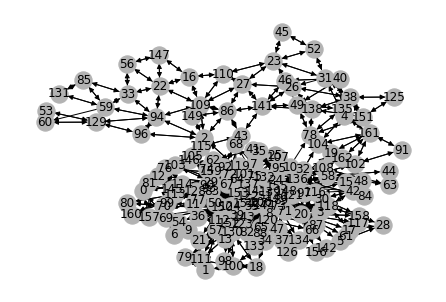

In [7]:
g = dgl.graph((rows, cols))
print(g.number_of_nodes)
import networkx as nx
nx_g = g.to_networkx()
pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [8]:
#Preprocess features

#active_cases = []
confirmed_cases = []
new_cases = []
new_vaccinations = []
fully_vaccinated = []
death_cases = []
static_feat = []

for i, each_loc in enumerate(loc_list):
    #active_cases.append(raw_data[raw_data['state'] == each_loc]['active'])
    confirmed_cases.append(raw_data[raw_data['location'] == each_loc]['total_cases'])
    new_cases.append(raw_data[raw_data['location'] == each_loc]['new_cases_smoothed'])
    new_vaccinations.append(raw_data[raw_data['location'] == each_loc]['new_vaccinations'])
    fully_vaccinated.append(raw_data[raw_data['location'] == each_loc]['people_fully_vaccinated'])
    death_cases.append(raw_data[raw_data['location'] == each_loc]['total_deaths'])
    static_feat.append(np.array(raw_data[raw_data['location'] == each_loc][['population']]))
confirmed_cases = np.nan_to_num(np.array(confirmed_cases))
death_cases = np.nan_to_num(np.array(death_cases)[:, 14:])
new_cases = np.nan_to_num(np.array(new_cases)[:, 14:])
new_vaccinations = np.nan_to_num(np.array(new_vaccinations)[:, 14:])
fully_vaccinated = np.nan_to_num(np.array(fully_vaccinated))
static_feat = np.nan_to_num(np.array(static_feat)[:, 0, :])

import copy
# active = confirmed(today) - confirmed(14 days ago)
cases_copy = copy.deepcopy(confirmed_cases)
active = []
for loc in confirmed_cases:
    active_loc = []
    for i in range(14, len(loc)):
        active_loc.append(loc[i] - loc[i-14])
    active.append(active_loc)
active_cases = np.array(active)

confirmed_cases = confirmed_cases[:, 14:]
fully_vaccinated = fully_vaccinated[:, 14:]

recovered_cases = confirmed_cases - active_cases - death_cases + 0.94*fully_vaccinated
susceptible_cases = np.expand_dims(static_feat[:, 0], -1) - active_cases - recovered_cases

# Batch_feat: new_cases(dI), dR, dS
#dI = np.array(new_cases)
dI = np.concatenate((np.zeros((active_cases.shape[0],1), dtype=np.float32), np.diff(active_cases)), axis=-1)
dR = np.concatenate((np.zeros((recovered_cases.shape[0],1), dtype=np.float32), np.diff(recovered_cases)), axis=-1)
dS = np.concatenate((np.zeros((susceptible_cases.shape[0],1), dtype=np.float32), np.diff(susceptible_cases)), axis=-1)
# number of new fully vaccinated each day
Vt = np.concatenate((np.zeros((fully_vaccinated.shape[0],1), dtype=np.float32), np.diff(fully_vaccinated)), axis=-1)
print("done")

done


In [9]:
#Build normalizer
normalizer = {'S':{}, 'I':{}, 'R':{}, 'dS':{}, 'dI':{}, 'dR':{}, 'Vt':{}}

for i, each_loc in enumerate(loc_list):
    normalizer['S'][each_loc] = (np.mean(susceptible_cases[i]), np.std(susceptible_cases[i]))
    normalizer['I'][each_loc] = (np.mean(active_cases[i]), np.std(active_cases[i]))
    normalizer['R'][each_loc] = (np.mean(recovered_cases[i]), np.std(recovered_cases[i]))
    normalizer['dI'][each_loc] = (np.mean(dI[i]), np.std(dI[i]))
    normalizer['dR'][each_loc] = (np.mean(dR[i]), np.std(dR[i]))
    normalizer['dS'][each_loc] = (np.mean(dS[i]), np.std(dS[i]))
    normalizer['Vt'][each_loc] = (np.mean(Vt[i]), np.std(Vt[i]))

In [10]:
def prepare_data(data, sum_I, sum_R, Vt, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    n_feat = data.shape[2]
    
    x = []
    y_I = []
    y_R = []
    last_I = []
    last_R = []
    concat_I = []
    concat_R = []
    concat_Vt = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
        
        concat_I.append(data[:, i+history_window-1, 0])
        concat_R.append(data[:, i+history_window-1, 1])
        last_I.append(sum_I[:, i+history_window-1])
        last_R.append(sum_R[:, i+history_window-1])

        y_I.append(data[:, i+history_window:i+history_window+pred_window, 0])
        y_R.append(data[:, i+history_window:i+history_window+pred_window, 1])

        concat_Vt.append(Vt[:, i+history_window:i+history_window+pred_window])
    x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
    last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
    last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
    concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
    concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
    y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
    y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
    concat_Vt = np.array(concat_Vt, dtype=np.float32).transpose((1, 0, 2))
    return x, last_I, last_R, concat_I, concat_R, y_I, y_R, concat_Vt

In [50]:
# re-run from here
valid_window = 25
test_window = 25

history_window=6
pred_window=15
slide_step=5

dynamic_feat = np.concatenate((np.expand_dims(dI, axis=-1), np.expand_dims(dR, axis=-1), np.expand_dims(dS, axis=-1)), axis=-1)
    
#Normalize
for i, each_loc in enumerate(loc_list):
    dynamic_feat[i, :, 0] = (dynamic_feat[i, :, 0] - normalizer['dI'][each_loc][0]) / normalizer['dI'][each_loc][1]
    dynamic_feat[i, :, 1] = (dynamic_feat[i, :, 1] - normalizer['dR'][each_loc][0]) / normalizer['dR'][each_loc][1]
    dynamic_feat[i, :, 2] = (dynamic_feat[i, :, 2] - normalizer['dS'][each_loc][0]) / normalizer['dS'][each_loc][1]
    mean_vax = normalizer['Vt'][each_loc][0]
    if mean_vax != 0:
        Vt[i] = (Vt[i] - mean_vax) / normalizer['Vt'][each_loc][1]
dI_mean = []
dI_std = []
dR_mean = []
dR_std = []

for i, each_loc in enumerate(loc_list):
    dI_mean.append(normalizer['dI'][each_loc][0])
    dR_mean.append(normalizer['dR'][each_loc][0])
    dI_std.append(normalizer['dI'][each_loc][1])
    dR_std.append(normalizer['dR'][each_loc][1])

dI_mean = np.array(dI_mean)
dI_std = np.array(dI_std)
dR_mean = np.array(dR_mean)
dR_std = np.array(dR_std)

#Split train-test
train_feat = dynamic_feat[:, :-valid_window-test_window, :]
val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR, train_Vt = prepare_data(train_feat, active_cases[:, :-valid_window-test_window], recovered_cases[:, :-valid_window-test_window], Vt[:, :-valid_window-test_window], history_window, pred_window, slide_step)
val_x, val_I, val_R, val_cI, val_cR, val_yI, val_yR, val_Vt = prepare_data(val_feat, active_cases[:, -valid_window-test_window:-test_window], recovered_cases[:, -valid_window-test_window:-test_window], Vt[:, -valid_window-test_window:-test_window], history_window, pred_window, slide_step)
test_x, test_I, test_R, test_cI, test_cR, test_yI, test_yR, test_Vt = prepare_data(test_feat, active_cases[:, -test_window:], recovered_cases[:, -test_window:], Vt[:, -test_window:], history_window, pred_window, slide_step)

In [51]:
#Build STAN model

in_dim = 3*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [52]:
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=18, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_res_I): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_R): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_sir): Linear(in_features=34, out_features=3, bias=True)
)

In [53]:
train_x = torch.tensor(train_x).to(device)
train_I = torch.tensor(train_I).to(device)
train_R = torch.tensor(train_R).to(device)
train_cI = torch.tensor(train_cI).to(device)
train_cR = torch.tensor(train_cR).to(device)
train_yI = torch.tensor(train_yI).to(device)
train_yR = torch.tensor(train_yR).to(device)
train_Vt = torch.tensor(train_Vt).to(device)

val_x = torch.tensor(val_x).to(device)
val_I = torch.tensor(val_I).to(device)
val_R = torch.tensor(val_R).to(device)
val_cI = torch.tensor(val_cI).to(device)
val_cR = torch.tensor(val_cR).to(device)
val_yI = torch.tensor(val_yI).to(device)
val_yR = torch.tensor(val_yR).to(device)
val_Vt = torch.tensor(val_Vt).to(device)

test_x = torch.tensor(test_x).to(device)
test_I = torch.tensor(test_I).to(device)
test_R = torch.tensor(test_R).to(device)
test_cI = torch.tensor(test_cI).to(device)
test_cR = torch.tensor(test_cR).to(device)
test_yI = torch.tensor(test_yI).to(device)
test_yR = torch.tensor(test_yR).to(device)
test_Vt = torch.tensor(test_Vt).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [54]:
#Train STAN

all_loss = []
file_name = './save/stan'
min_loss = 1e10

loc_name = 'India'
cur_loc = loc_list.index(loc_name)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    
    active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc], V=train_Vt[cur_loc])
    phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
    loss = criterion(active_pred.squeeze(), train_yI[cur_loc])+criterion(recovered_pred.squeeze(), train_yR[cur_loc])+0.1*criterion(phy_active.squeeze(), train_yI[cur_loc])+0.1*criterion(phy_recover.squeeze(), train_yR[cur_loc])
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc], V=train_Vt[cur_loc])
    val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h, V=val_Vt[cur_loc])
    
    val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    val_loss = criterion(val_active_pred.squeeze(), val_yI[cur_loc]) + 0.1*criterion(val_phy_active.squeeze(), val_yI[cur_loc])
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss
        print('-----Save best model-----')
    
    print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, all_loss[-1], val_loss.item()))

C:\Users\conni\anaconda3\envs\tf-gpu\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
-----Save best model-----
Epoch 0, Loss 195795.95, Val loss 36728.21
-----Save best model-----
Epoch 1, Loss 34180.77, Val loss 10363.15
-----Save best model-----
Epoch 2, Loss 10741.52, Val loss 4216.90
-----Save best model-----
Epoch 3, Loss 2351.41, Val loss 1702.73
-----Save best model-----
Epoch 4, Loss 1391.26, Val loss 890.84
-----Save best model-----
Epoch 5, Loss 1147.29, Val loss 534.56
-----Save best model-----
Epoch 6, Loss 516.11, Val loss 378.07
-----Save best model-----
Epoch 7, Loss 217.32, Val loss 200.75
Epoch 8, Loss 139.57, Val loss 213.74
-----Save best model-----
Epoch 9, Loss 124.30, Val loss 115.02
-----Save 

In [55]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()


prev_x = torch.cat((train_x, val_x), dim=1)
prev_I = torch.cat((train_I, val_I), dim=1)
prev_R = torch.cat((train_R, val_R), dim=1)
prev_cI = torch.cat((train_cI, val_cI), dim=1)
prev_cR = torch.cat((train_cR, val_cR), dim=1)
prev_Vt = torch.cat((train_Vt, val_Vt), dim=1)
prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc], V=prev_Vt[cur_loc])


test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h, V=test_Vt[cur_loc])


In [56]:
print('Estimated beta in SIR model is %.2f'%model.alpha_scaled)
print('Estimated gamma in SIR model is %.2f'%model.beta_scaled)
print('Estimated theta in SIR model is %.2f'%model.theta_scaled)

Estimated beta in SIR model is 0.01
Estimated gamma in SIR model is 0.23
Estimated theta in SIR model is 0.03


In [57]:
#Cumulate predicted dI
pred_I = []

for i in range(test_pred_active.size(1)):
    # below is regular prediction
    cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
    # below is SIR model prediction
    #cur_pred = test_pred_phy_active[0, i, :].detach().cpu().numpy()
    # below is average of the two predictions
    #cur_pred = (cur_pred + test_pred_phy_active[0, i, :].detach().cpu().numpy()) / 2
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
    pred_I.append(cur_pred)
pred_I = np.array(pred_I)

In [58]:
def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    
    y = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        y.append(data[:, i+history_window:i+history_window+pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

In [59]:
I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

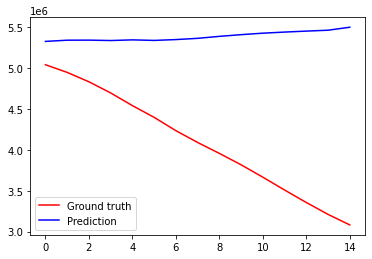

In [60]:
plt.plot(I_true[cur_loc, -1, :],c='r', label='Ground truth')
plt.plot(pred_I[-1, :],c='b', label='Prediction')
plt.legend()
plt.show()